## Dannys Diner - Case study #1

In [1]:
import sys

In [2]:
# !{sys.executable} -m pip install jupysql

In [3]:
%load_ext sql
%sql sqlite:///diner.db
%config SqlMagic.displaylimit = None

Connecting to 'sqlite:///diner.db'

displaylimit: Value None will be treated as 0 (no limit)

### Crear y relacionar tablas

### Relación de las tablas

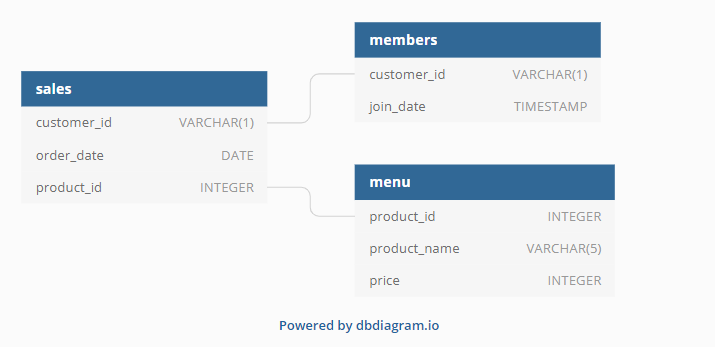

Crear e insertar datos en tabla `members`:

In [4]:
%%sql
DROP TABLE IF EXISTS members;

CREATE TABLE IF NOT EXISTS members(
    customer_id varchar(1) PRIMARY KEY NOT NULL UNIQUE,
    join_date DATETIME
);

--inserta datos
INSERT INTO members
  ("customer_id", "join_date")
VALUES
  ('A', '2021-01-07'),
  ('B', '2021-01-09');

Running query in 'sqlite:///diner.db'

++
||
++
++

In [5]:
%sql select * from members;

Running query in 'sqlite:///diner.db'

customer_id,join_date
A,2021-01-07
B,2021-01-09


Crear e insertar datos en tabla `menu`:

In [6]:
%%sql
DROP TABLE IF EXISTS menu;

CREATE TABLE IF NOT EXISTS menu(
    product_id INTEGER PRIMARY KEY NOT NULL UNIQUE,
    product_name varchar(10),
    price INTEGER NOT NULL
);

--valores para menu
INSERT INTO menu
  ("product_id", "product_name", "price")
VALUES
  ('1', 'sushi', '10'),
  ('2', 'curry', '15'),
  ('3', 'ramen', '12');

Running query in 'sqlite:///diner.db'

++
||
++
++

In [7]:
%sql select * from menu;

Running query in 'sqlite:///diner.db'

product_id,product_name,price
1,sushi,10
2,curry,15
3,ramen,12


Crear e insertar datos en tablas `sales`:

In [8]:
%%sql
DROP TABLE IF EXISTS sales;

CREATE TABLE IF NOT EXISTS sales(
    customer_id varchar(1) NOT NULL,
    order_date DATE NOT NULL,
    product_id INTEGER NOT NULL,
    FOREIGN KEY(customer_id) REFERENCES members(customer_id),
    FOREIGN KEY(product_id) REFERENCES menu(product_id)
);

--insertar datos en sales

INSERT INTO sales
  ("customer_id", "order_date", "product_id")
VALUES
  ('A', '2021-01-01', '1'),
  ('A', '2021-01-01', '2'),
  ('A', '2021-01-07', '2'),
  ('A', '2021-01-10', '3'),
  ('A', '2021-01-11', '3'),
  ('A', '2021-01-11', '3'),
  ('B', '2021-01-01', '2'),
  ('B', '2021-01-02', '2'),
  ('B', '2021-01-04', '1'),
  ('B', '2021-01-11', '1'),
  ('B', '2021-01-16', '3'),
  ('B', '2021-02-01', '3'),
  ('C', '2021-01-01', '3'),
  ('C', '2021-01-01', '3'),
  ('C', '2021-01-07', '3');

Running query in 'sqlite:///diner.db'

++
||
++
++

In [9]:
%sql select * from sales;

Running query in 'sqlite:///diner.db'

customer_id,order_date,product_id
A,2021-01-01,1
A,2021-01-01,2
A,2021-01-07,2
A,2021-01-10,3
A,2021-01-11,3
A,2021-01-11,3
B,2021-01-01,2
B,2021-01-02,2
B,2021-01-04,1
B,2021-01-11,1


**1. ¿Cuál es la cantidad total que gastó cada cliente?**

In [10]:
%%sql
SELECT
    a.customer_id as Customer,
    count(a.customer_id) as Total_com,
    sum(b.price) as Total_amount
FROM
    sales a
LEFT JOIN
    menu b On (a.product_id = b.product_id)
GROUP BY a.customer_id
ORDER BY Total_amount DESC;

Running query in 'sqlite:///diner.db'

Customer,Total_com,Total_amount
A,6,76
B,6,74
C,3,36


**2. ¿Cuántos días ha visitado cada cliente el restaurante?**

In [11]:
%%sql
SELECT
    customer_id as Customer,
    COUNT(DISTINCT(order_date)) as Total_visit
FROM
    sales
GROUP BY customer_id
ORDER BY Total_visit DESC;

Running query in 'sqlite:///diner.db'

Customer,Total_visit
B,6
A,4
C,2


Se toma en cuenta `DISTINCT` para evitar duplicar el recuento de visitas por días.

**3. ¿Cuál fue el primer artículo comprado por cada cliente?**

In [12]:
%%sql
WITH f_buy as(
    SELECT
        a.customer_id,
        a.order_date,
        b.product_name,
        dense_rank() over(partition by a.customer_id order by a.order_date) as rank
    FROM
        sales a
    LEFT JOIN
        menu b on(a.product_id = b.product_id))
SELECT
    customer_id,
    order_date,
    product_name
FROM
    f_buy
WHERE rank=1
GROUP BY customer_id, product_name;

Running query in 'sqlite:///diner.db'

customer_id,order_date,product_name
A,2021-01-01,curry
A,2021-01-01,sushi
B,2021-01-01,curry
C,2021-01-01,ramen


**Explicación**:

`dense_rank()`: la función no toma argumentos, pero se necesitan los paréntesis vacíos.

`OVER`: las cláusulas de ventana para la función `dense_rank`.

`partition by`: (opcional) una o más exprsiones que definen la ventan.

`order by`: la expresión en que se bansan los valores de clasificación. Si no
especifica `partition by`, `òrder by` utiliza toda la tabla. Si se omite `order by`,
el valor de retorno es `1` para todas las filas.

`dense_rank` asigna de `1` hasta `n` en base al orden de `order_date` y restablece el
conteo en `1` por cada partición de `customer_id`.

>Parece se puede aplicar `row_number()`, pero podría no determinar la secuencia exacta al no tener una marca de tiempo.

**4. ¿Cuál es el artículo más comprado en el menú y cuántas veces fue comprado por todos cada cliente?**

In [13]:
%%sql
SELECT
    b.product_name as Pname,
    count(b.product_id) as More_sale
FROM
    sales a
LEFT JOIN
    menu b  ON(a.product_id = b.product_id)
GROUP BY a.product_id
ORDER BY More_sale DESC;

Running query in 'sqlite:///diner.db'

Pname,More_sale
ramen,8
curry,4
sushi,3


Muestra el nombre de producto junto a la cantidad de veces compradas.

**5. ¿Qué artículo fue el más popular por cada cliente?**

In [14]:
%%sql
WITH popitems as(
    SELECT
        a.customer_id,
        b.product_name,
        count(b.product_name) as or_count,
        dense_rank() over(partition by a.customer_id
                          order by count(b.product_name) DESC) as rank
    FROM
        sales a
    LEFT JOIN
        menu b ON(a.product_id = b.product_id)
    GROUP BY a.customer_id, b.product_name
)
SELECT
    customer_id as Customer,
    product_name as "Product name",
    or_count as "Popular foo"
FROM
    popitems
WHERE rank=1;

Running query in 'sqlite:///diner.db'

Customer,Product name,Popular foo
A,ramen,3
B,sushi,2
B,ramen,2
B,curry,2
C,ramen,3


**5. Primer artículo comprado por el clientes depués de ser miembro.**

In [15]:
%%sql
WITH after_member as(
    SELECT
        a.customer_id,
        b.product_name,
        c.join_date,
        a.order_date,
        row_number() over(partition by a.customer_id order by a.order_date) as row_number
    FROM 
        sales a
    LEFT JOIN
        menu b ON(a.product_id = b.product_id)
    LEFT JOIN
        members c ON(a.customer_id = c.customer_id)
    WHERE a.order_date > c.join_date
)
SELECT
    customer_id as Customer,
    join_date as "Member from",
    product_name as "Product name",
    order_date as "Date Purchased"
FROM
    after_member
WHERE row_number=1;

Running query in 'sqlite:///diner.db'

Customer,Member from,Product name,Date Purchased
A,2021-01-07,ramen,2021-01-10
B,2021-01-09,sushi,2021-01-11


**7. ¿Qué artículo compró el cliente antes de ser miembro?**

In [16]:
%%sql
WITH before_member as(
    SELECT
        a.customer_id,
        b.product_name,
        c.join_date,
        a.order_date,
        row_number() over(partition by a.customer_id order by a.order_date DESC) as rank
    FROM
        sales a
    LEFT JOIN
        menu b ON(a.product_id = b.product_id)
    LEFT JOIN
        members c ON(a.customer_id = c.customer_id)
    WHERE a.order_date < c.join_date
)
SELECT
    customer_id as Customer,
    join_date as "Member from",
    product_name as "Product name",
    order_date as "Date Purchased"
FROM
    before_member
WHERE rank=1;

Running query in 'sqlite:///diner.db'

Customer,Member from,Product name,Date Purchased
A,2021-01-07,sushi,2021-01-01
B,2021-01-09,sushi,2021-01-04


`row_number()` ordena `order_date` de mayor a menor para asignarle `1` antes de la fecha
de membresía, además de enumerar de manera consecutiva sin importar el `order by`,
por lo que no repite la asignación de `1`.

**8. Total de artículos y cantidad gastada por el cliente antes de ser miembo.**

In [17]:
%%sql
SELECT
    a.customer_id as Customer,
    count(a.product_id) as "Total articles",
    sum(b.price) as "Total amount"
FROM
    sales a
LEFT JOIN
    menu b ON(a.product_id = b.product_id)
LEFT JOIN
    members c ON(a.customer_id = c.customer_id)
WHERE a.order_date < c.join_date
GROUP BY a.customer_id;

Running query in 'sqlite:///diner.db'

Customer,Total articles,Total amount
A,2,25
B,3,40


**9. Si cada $1 gastado equivale a 10 puntos y el sushi tiene el doble de puntos, ¿cuántos puntos tendría cada cliente?**

Usando un subquery:

In [18]:
%%sql
SELECT
	a.customer_id as Customer,
	sum(b.points) as Points
FROM
    sales a
LEFT JOIN
    (SELECT product_id,
		CASE WHEN product_id = 1 THEN price * 20
			ELSE price * 10
		END as points
	FROM menu) b on(a.product_id = b.product_id)
GROUP BY a.customer_id;

Running query in 'sqlite:///diner.db'

Customer,Points
A,860
B,940
C,360


Alternativamente usando una expresión de tabla común (CTE):

In [19]:
%%sql
WITH points_cte as (
    SELECT
        product_id,
        CASE WHEN product_id = 1 THEN price * 20
            ELSE price * 10
        END as points
    FROM
        menu
)
SELECT
    a.customer_id,
    sum(b.points) as Points
FROM
    sales a
LEFT JOIN
    points_cte b on(a.product_id = b.product_id)
GROUP BY a.customer_id
ORDER BY a.customer_id;

Running query in 'sqlite:///diner.db'

customer_id,Points
A,860
B,940
C,360


**10. En la primera semana después de que el cliente se une al programa (incluida su fecha de inicio) gana 2x
puntos en todos los artículos, no solo el sushi. ¿Cuántos puntos tienen los clientes A y B a fines de enero?**

In [20]:
%%sql
WITH dates_cte AS (
    SELECT 
    customer_id, 
        join_date, 
    DATE(join_date, '+6 day') as valid_date, 
        DATE('2021-01-31', '+1 month', '-1 day') as last_date
    FROM
        members
)

SELECT
    a.customer_id, 
    SUM(CASE WHEN c.product_name = ('sushi') THEN 2 * 10 * c.price
        WHEN a.order_date BETWEEN b.join_date AND b.valid_date THEN 2 * 10 * c.price
        ELSE 10 * c.price
    END) AS points
FROM
    sales a
LEFT JOIN
    dates_cte b on(a.customer_id = b.customer_id)

LEFT JOIN
    menu c on(a.product_id = c.product_id)
WHERE b.join_date <= a.order_date AND a.order_date <= b.last_date
GROUP BY a.customer_id;

Running query in 'sqlite:///diner.db'

customer_id,points
A,1020
B,440
